In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = ""

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "blastchar/telco-customer-churn",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df.head()

/tmp/ipykernel_36/644689689.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ValueError: Unsupported file extension: ''. Supported file extensions are: .csv, .tsv, .json, .jsonl, .xml, .parquet, .feather, .sqlite, .sqlite3, .db, .db3, .s3db, .dl3, .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt

# Checking If DataSet Exist In The Input

In [1]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/telco-customer-churn


## **Importing neccessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###  **Loading the dataset**

In [3]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

####  Since there are 16 columns(excluding the customerID, Tenure, MonthlyCharges, TotalCharges, Churn), 

#### we will apply 

####  **Chi-Square Test of dependence**

In [5]:
from scipy.stats import chi2_contingency

categorical_columns = [
    "gender", 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
    'PaymentMethod'
]

features = []

for column in categorical_columns:
    contingency_table = pd.crosstab(df[column], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    features.append({"Feature":column, "Chi2": chi2, "p-value":p})

chi2_result = pd.DataFrame(features).sort_values("p-value")

print("Your Chi2 Results\n", chi2_result)

Your Chi2 Results
              Feature         Chi2        p-value
13          Contract  1184.596572  5.863038e-258
7     OnlineSecurity   849.998968  2.661150e-185
10       TechSupport   828.197068  1.443084e-180
6    InternetService   732.309590  9.571788e-160
15     PaymentMethod   648.142327  3.682355e-140
8       OnlineBackup   601.812790  2.079759e-131
9   DeviceProtection   558.419369  5.505219e-122
12   StreamingMovies   375.661479   2.667757e-82
11       StreamingTV   374.203943   5.528994e-82
14  PaperlessBilling   258.277649   4.073355e-58
3         Dependents   189.129249   4.924922e-43
1      SeniorCitizen   159.426300   1.510067e-36
2            Partner   158.733382   2.139911e-36
5      MultipleLines    11.330441   3.464383e-03
4       PhoneService     0.915033   3.387825e-01
0             gender     0.484083   4.865787e-01


####  Now that we have the 16 features and their Chi2's, let's filter based on 
#### **p-value < 0.05**

In [6]:
# Sort features by p-value ascending (strongest signals first)
sorted_features = sorted(features, key=lambda x: x['p-value'])

# Keep top 5 strongest (example)
strongest_features = [f['Feature'] for f in sorted_features[:5]]

print("Strongest Features (lowest p-values):\n", strongest_features)

Strongest Features (lowest p-values):
 ['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod']


#### Tenure, MonthlyCharges, and TotalCharges are numeric values, so we will perform 

#### **ANOVA**

In [7]:
from scipy.stats import f_oneway

df['Churn'] = df['Churn'].astype('category')

In [8]:
# Ensure numeric columns are really numeric
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # invalid values → NaN

# Drop rows with missing values in these columns
df = df.dropna(subset=['tenure', 'MonthlyCharges', 'TotalCharges'])

In [9]:
anova_results = []

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_features:
    # Split into churned vs not churned
    groups = [df[df['Churn'] == level][col].dropna() for level in df['Churn'].unique()]
    
    # One-way ANOVA
    f_stat, p_val = f_oneway(*groups)
    anova_results.append({"Feature": col, "F-statistic": f_stat, "p-value": p_val})

anova_df = pd.DataFrame(anova_results).sort_values("p-value")
print(anova_df)

          Feature  F-statistic        p-value
0          tenure  1007.509431  9.437650e-207
2    TotalCharges   291.344862   4.876866e-64
1  MonthlyCharges   271.576990   6.760843e-60


#### From One-way ANOVA, we can tell that all 3 features play a crucial role when build an 
#### **ANN Model for Churn Modelling**

In [10]:
important_features = [
    'Contract', 
    'OnlineSecurity', 
    'TechSupport', 
    'InternetService', 
    'PaymentMethod',
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
]

target = 'Churn'

In [11]:
df.shape

(7032, 21)

In [12]:
X = df[important_features]

X.head()

,Contract,OnlineSecurity,TechSupport,InternetService,PaymentMethod,tenure,MonthlyCharges,TotalCharges
0,Month-to-month,No,No,DSL,Electronic check,1,29.85,29.85
1,One year,Yes,No,DSL,Mailed check,34,56.95,1889.50
2,Month-to-month,Yes,No,DSL,Mailed check,2,53.85,108.15
3,One year,Yes,Yes,DSL,Bank transfer (automatic),45,42.30,1840.75
4,Month-to-month,No,No,Fiber optic,Electronic check,2,70.70,151.65


In [13]:
y = df[target]

y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: category
Categories (2, object): ['No', 'Yes']

### Normalizing all the Important Features

In [15]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

## 'Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod',

categorical_features = ['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod']
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", MinMaxScaler(), numeric_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

print(X_processed[0])

[1.         0.         0.         1.         0.         0.
 1.         0.         0.         1.         0.         0.
 0.         0.         1.         0.         0.         0.11542289
 0.0012751 ]


In [16]:
# Get encoded column names for the categorical features
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine with numeric features
all_feature_names = list(encoded_feature_names) + numeric_features

# Build DataFrame with correct columns
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

X_processed_df.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.115423,0.001275
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.464789,0.385075,0.215867
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.014085,0.354229,0.010310
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.619718,0.239303,0.210241
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.014085,0.521891,0.015330


In [17]:
X_processed_df.shape

(7032, 19)

In [18]:
# Convert Yes/No to 1/0
y = y.map({"No": 0, "Yes": 1}).astype(int)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_processed_df, y, test_size=0.33, random_state=42)

X_train.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
5758,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.901408,0.413433,0.437272
5352,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.042254,0.021393,0.007610
5736,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.845070,0.059204,0.164597
6056,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.816901,0.067164,0.172132
229,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.647887,0.667164,0.471781


In [20]:
y_train.head()

5767    0
5361    0
5745    0
6065    0
229     0
Name: Churn, dtype: int64

#### Now that we have the training and testing data, 

#### We will make an **ANN Model**

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras import Sequential

2025-09-06 08:44:19.047078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757148259.333427      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757148259.415215      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
model = Sequential()

####  Adding the first layer of the ANN

In [23]:
input_dim = X_processed_df.shape[1]

model.add(
    Dense(
        units=64,
        activation="relu",
        input_shape=(input_dim,)
    )
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-06 08:44:47.460245: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
model.add(
    Dense(
        units=32,
        activation="relu",
    )
)

model.add(
    Dense(
        units=16,
        activation="relu",
    )
)

#### Adding the final output layer

In [25]:
model.add(
    Dense(
        units=1,
        activation="sigmoid",
    )
)

#### Compiling the ANN model

In [26]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

#### Training the Model

In [27]:


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6941 - loss: 0.5580 - val_accuracy: 0.7820 - val_loss: 0.4495
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7852 - loss: 0.4283 - val_accuracy: 0.7863 - val_loss: 0.4341
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7865 - loss: 0.4299 - val_accuracy: 0.7902 - val_loss: 0.4349
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7933 - loss: 0.4190 - val_accuracy: 0.7915 - val_loss: 0.4315
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7941 - loss: 0.4239 - val_accuracy: 0.7923 - val_loss: 0.4351
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7941 - loss: 0.4235 - val_accuracy: 0.7889 - val_loss: 0.4401
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7966 - loss: 0.4261 - val_accuracy: 0.7928 - val_loss: 0.4331
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7957 - loss: 0.4185 - val_accuracy: 0.

#### Representation of Our **Telco Customer ANN Churn Model**

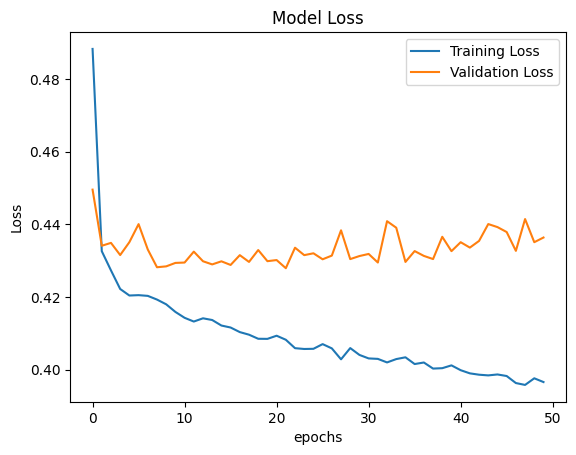

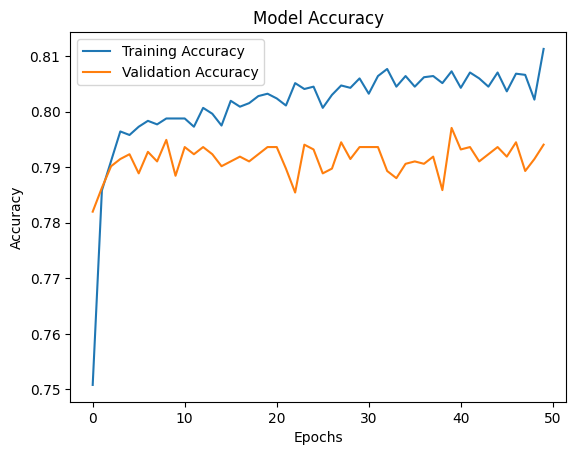

In [28]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Model Loss')
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

#### Since, our model is ready, we can begin the 

### **Prediction Phase**

In [29]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7941


#### Adding SHAP (explainability) → show which features cause churn.

In [30]:
!pip install shap

PermutationExplainer explainer: 101it [00:18,  3.54it/s]                         


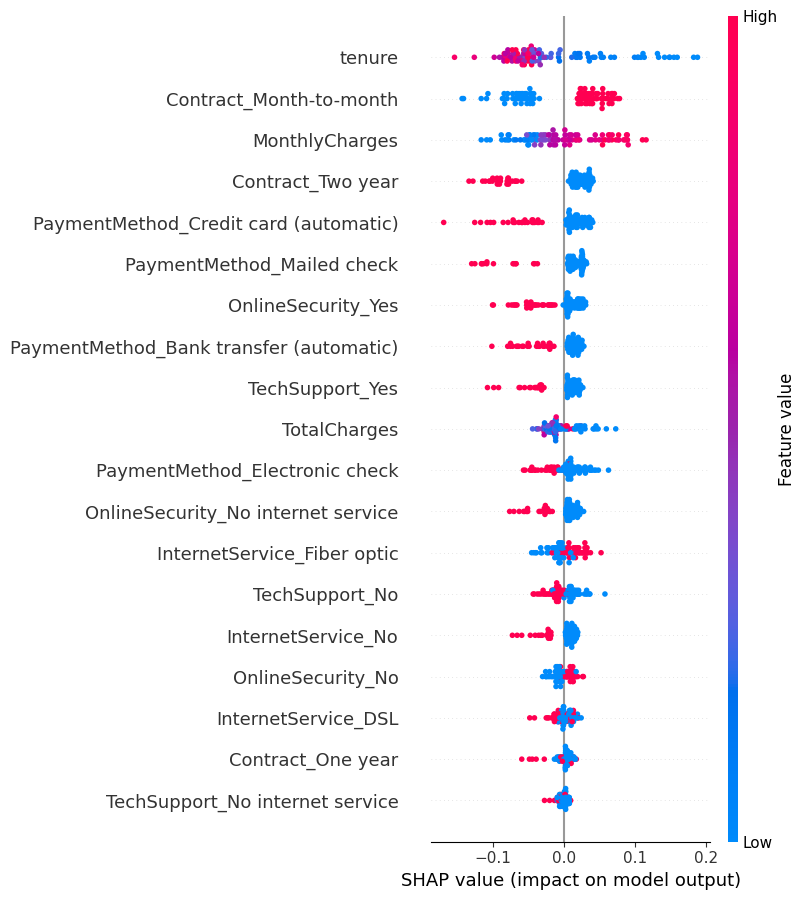

In [34]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for a subset of data
shap_values = explainer(X_val[:100])  # first 100 test samples

shap.summary_plot(shap_values, X_val[:100])

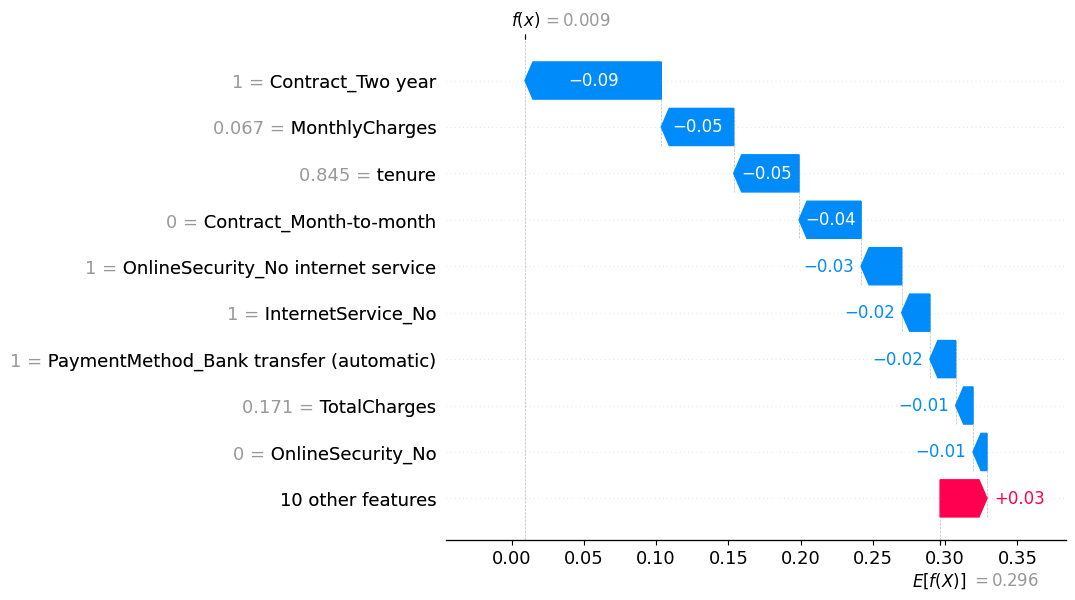

In [37]:
shap.plots.waterfall(shap_values[0])